In [22]:
# Install Packages

# for path handling
import pathlib

# for loading images into numpy
import imageio

import numpy as np
import pandas as pd

# for greyscale conversion
from skimage.color import rgb2gray

# for plotting
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.utils as keras_utils


# Reading Data and Data Preparation

no longer used: https://www.kaggle.com/code/vanausloos/how-to-read-images-in-python/notebook
https://www.tensorflow.org/tutorials/load_data/images

In [17]:
# get paths to images
paths_to_images = pathlib.Path('./images').glob('**/*.jpeg')
paths_sorted = sorted([x for x in paths_to_images])


In [18]:
# loading data with keras utility

path_to_data = "./images/training"

batch_size = 32
# get image dimensions
img_height, img_width = imageio.imread(paths_sorted[0]).shape[:2]

train_data: tf.data.Dataset = keras_utils.image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training"
)

validation_data: tf.data.Dataset = keras_utils.image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"
)

# check if data was read correctly
class_names = train_data.class_names
print(f"Class names: {class_names}")


Found 136 files belonging to 2 classes.
Using 109 files for training.
Found 136 files belonging to 2 classes.
Using 27 files for validation.
Class names: ['fullys', 'hardtails']


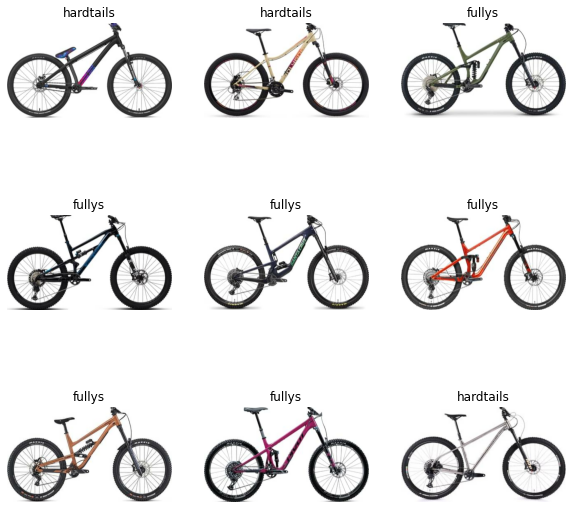

In [19]:
# plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [21]:
# print dimmensions
# 32 => batch of 32 images
# 232 => height of image
# 400 => width of image
# 3 => RGB
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 232, 400, 3)
(32,)


In [25]:
# normalization

# initialize normalization layer
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

# this layer will later be used by the model

In [26]:
# Performace tweaks

train_data = train_data.cache().prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
validation_data = validation_data.cache().prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)


In [29]:
num_classes = len(class_names)

model = keras.Sequential([
    normalization_layer,  # here we reuse the normalization layer
    keras.layers.Conv2D(32, 3, activation='relu'),  # Convolutional layer
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [30]:
# train model
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)


Epoch 1/10
4/4 [==============================] - 7s 2s/step - loss: 1.9712 - accuracy: 0.5046 - val_loss: 0.6528 - val_accuracy: 0.6296
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 0.7174 - accuracy: 0.5505 - val_loss: 0.6640 - val_accuracy: 0.6296
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 0.5810 - accuracy: 0.8165 - val_loss: 0.5419 - val_accuracy: 0.7407
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 0.4292 - accuracy: 0.8440 - val_loss: 0.3817 - val_accuracy: 0.8519
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 0.2940 - accuracy: 0.8807 - val_loss: 0.2742 - val_accuracy: 0.8519
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 0.2046 - accuracy: 0.8991 - val_loss: 0.2031 - val_accuracy: 0.8889
Epoch 7/10
4/4 [==============================] - 7s 2s/step - loss: 0.1118 - accuracy: 0.9725 - val_loss: 0.1350 - val_accuracy: 0.9630
Epoch 8/10
4/4 [=========================

In [33]:
# evaluation
# TRAIN
for image_batch, labels_batch in train_data:
    test_loss, test_acc = model.evaluate(image_batch, labels_batch, verbose=2)
    print(test_loss, test_acc)
    break

# TEST
for image_batch, labels_batch in validation_data:
    test_loss, test_acc = model.evaluate(image_batch, labels_batch, verbose=2)
    print(test_loss, test_acc)
    break

1/1 - 0s - loss: 0.0098 - accuracy: 1.0000
0.009805259294807911 1.0
1/1 - 0s - loss: 0.0205 - accuracy: 1.0000
0.020508399233222008 1.0


In [37]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [36]:
# predict
pred = []
for image_batch,labels_batch in validation_data:
    prediction = model.predict(image_batch)
    pred = prediction
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


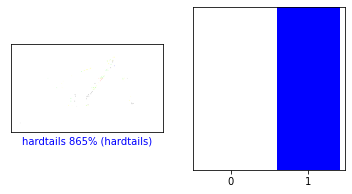

In [41]:
for test_images, test_labels in validation_data:
    i = 0
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plot_image(i, pred[i], test_labels, test_images)
    plt.subplot(1, 2, 2)
    plot_value_array(i, pred[i],  test_labels)
    plt.show()
    break
